In [6]:
import os
import torch
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid

In [3]:
dataset = Planetoid(root='data/Planetoid', name='CiteSeer')
print(f'Dataset: {dataset}')
print(20*'=')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: CiteSeer()
Number of graphs: 1
Number of features: 3703
Number of classes: 6


Done!


In [7]:
data = dataset[0]
print(data)
print(30*'=')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degress: {data.num_nodes/data.num_edges:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum())/data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degress: 0.37
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [8]:
def visualize_graph(G, color):
    plt.figure(figsize=(75,75))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=False, node_color=color, cmap="Set2")
    plt.show()

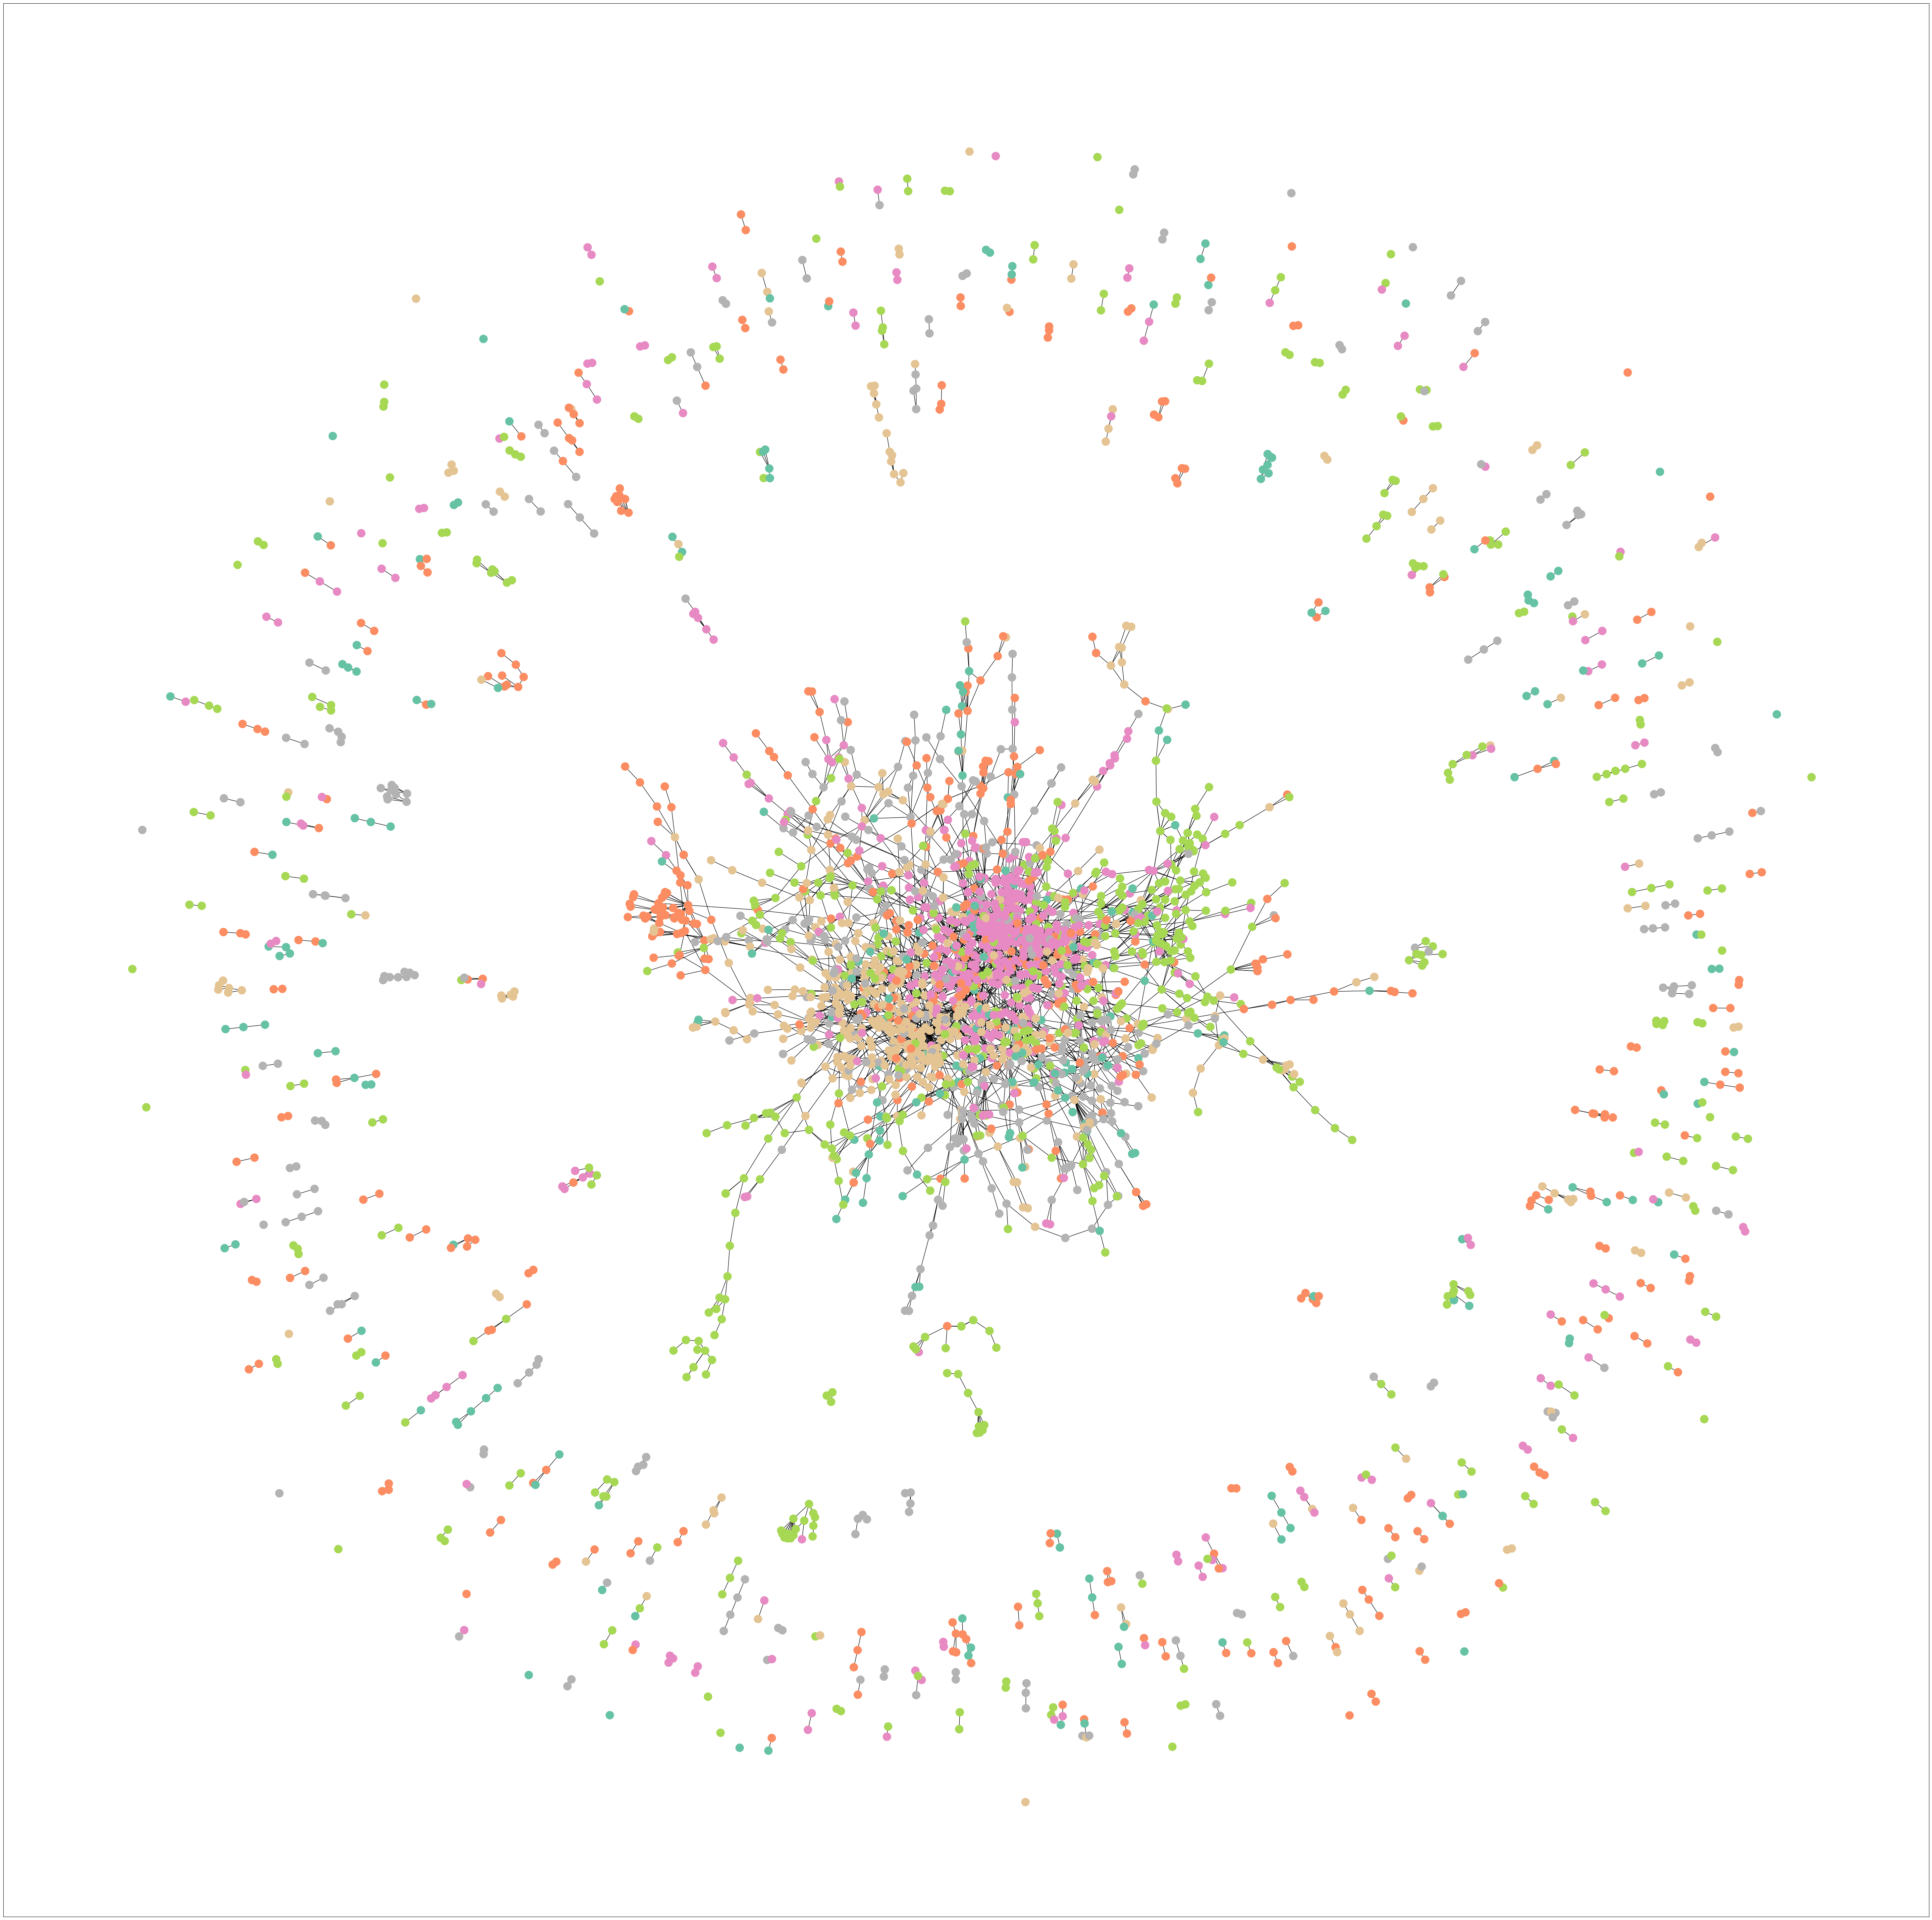

In [9]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

# Graph Model 1: Classic MLP

In [11]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training) # training argument used so that dropout is only used during training (as it should b/c regularization tech)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=3703, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=6, bias=True)
)


In [16]:
def visualize(data, labels):
    tsne = TSNE(n_components=2, init='pca', random_state=7)
    tsne_res = tsne.fit_transform(data)
    v = pd.DataFrame(data, columns=[str(i) for i in range(data.shape[1])])
    v['color'] = labels
    v['label'] = v['color'].apply(lambda i: str(i))
    v['dim1'] = tsne_res[:, 0]
    v['dim2'] = tsne_res[:, 1]
    plt.figure(figsize=(12,12))
    sns.scatterplot(
        x='dim1', y='dim2',
        hue='color',
        palette=sns.color_palette(["#52D1DC", "#8D0004", "#845218","#563EAA", "#E44658", "#63C100", "#FF7800"]),
        legend=False,
        data=v
    )

/var/folders/3j/nswsh09j5rxcg8c7sj06k4080000gn/T/ipykernel_80538/2097714774.py:10: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


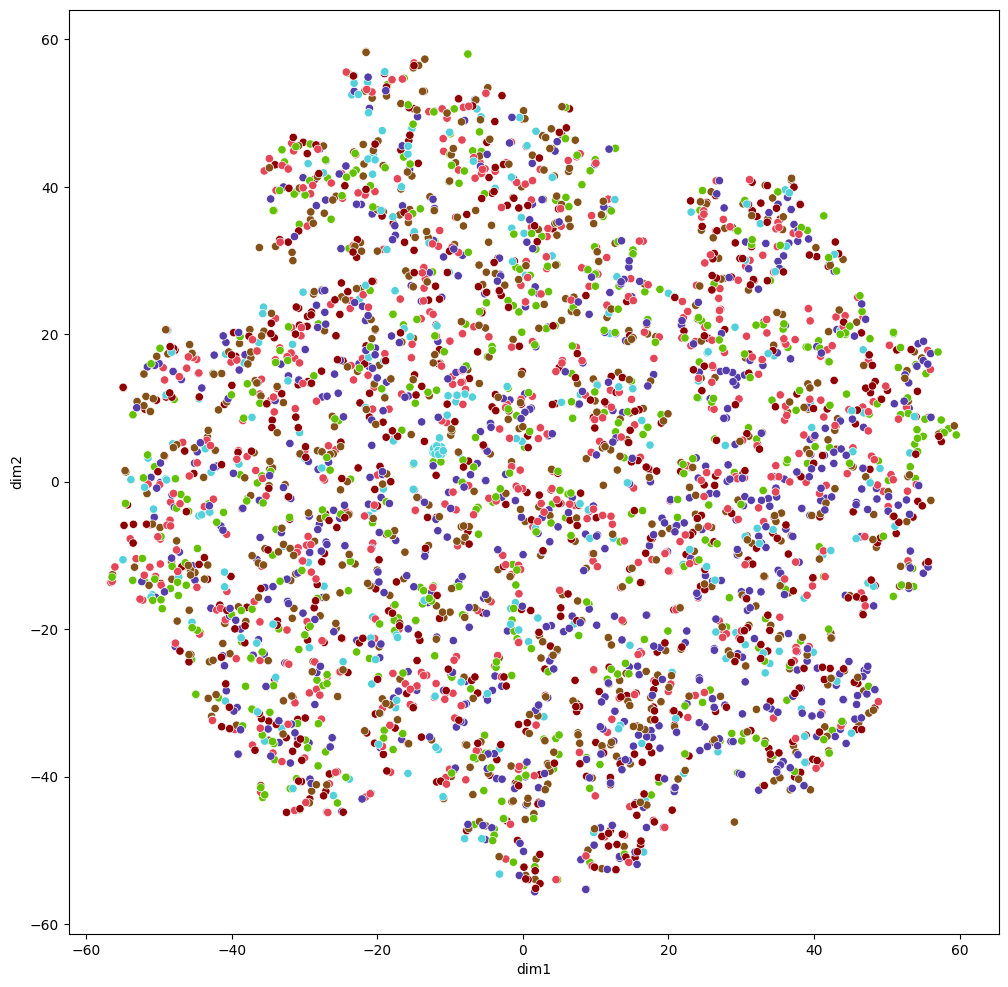

In [17]:
model.eval()
out = model(data.x)
visualize(out.detach().cpu().numpy(), data.y)

In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) # loss based only on training data
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}')

Epoch: 001, Loss: 1.8018, Val: 0.1020
Epoch: 002, Loss: 1.7394, Val: 0.1360
Epoch: 003, Loss: 1.6380, Val: 0.2040
Epoch: 004, Loss: 1.5198, Val: 0.2920
Epoch: 005, Loss: 1.3852, Val: 0.4000
Epoch: 006, Loss: 1.2553, Val: 0.4520
Epoch: 007, Loss: 1.1171, Val: 0.4920
Epoch: 008, Loss: 0.9734, Val: 0.5080
Epoch: 009, Loss: 0.9092, Val: 0.5200
Epoch: 010, Loss: 0.7803, Val: 0.5200
Epoch: 011, Loss: 0.6895, Val: 0.5220
Epoch: 012, Loss: 0.5818, Val: 0.5100
Epoch: 013, Loss: 0.5737, Val: 0.5160
Epoch: 014, Loss: 0.5050, Val: 0.5160
Epoch: 015, Loss: 0.5076, Val: 0.5160
Epoch: 016, Loss: 0.3981, Val: 0.5180
Epoch: 017, Loss: 0.3638, Val: 0.5260
Epoch: 018, Loss: 0.3637, Val: 0.5200
Epoch: 019, Loss: 0.3537, Val: 0.5220
Epoch: 020, Loss: 0.3484, Val: 0.5260
Epoch: 021, Loss: 0.3080, Val: 0.5320
Epoch: 022, Loss: 0.3332, Val: 0.5300
Epoch: 023, Loss: 0.2689, Val: 0.5180
Epoch: 024, Loss: 0.2807, Val: 0.5220
Epoch: 025, Loss: 0.2697, Val: 0.5180
Epoch: 026, Loss: 0.3087, Val: 0.5160
Epoch: 027, 

In [21]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5590


/var/folders/3j/nswsh09j5rxcg8c7sj06k4080000gn/T/ipykernel_80538/2097714774.py:10: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


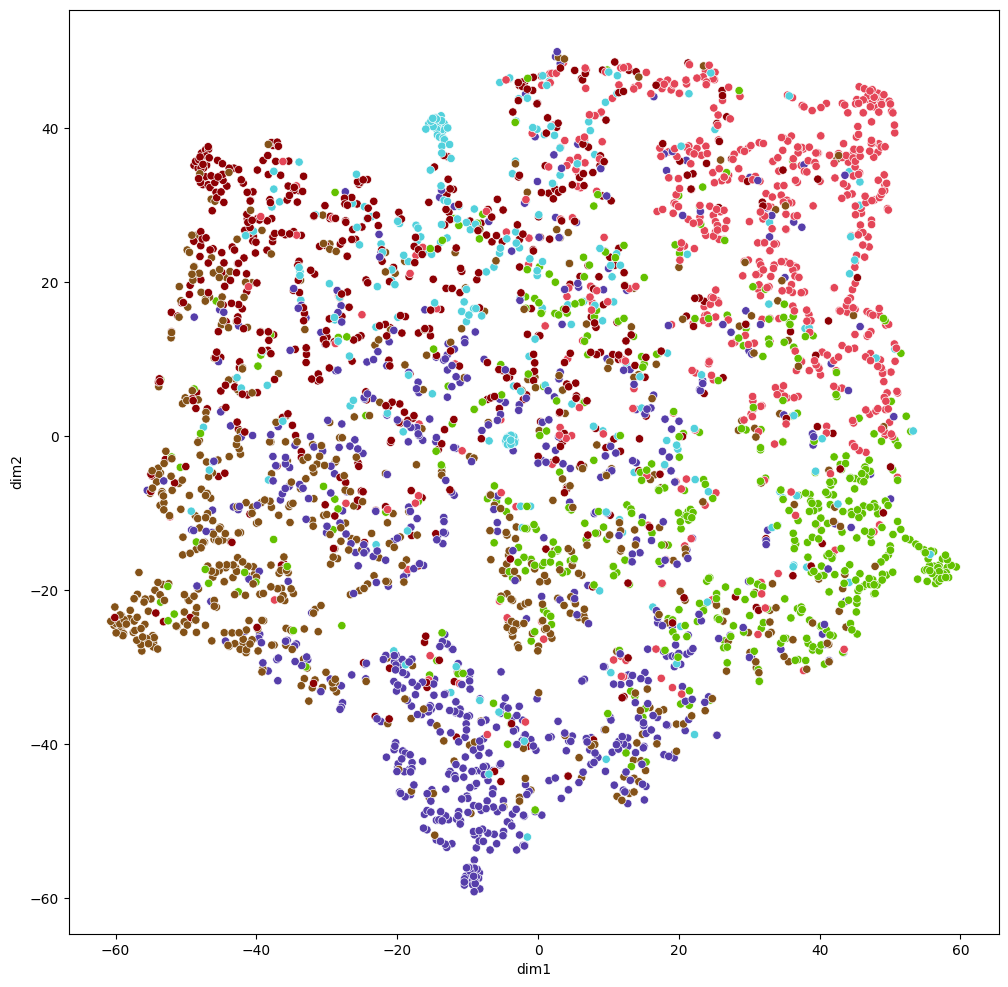

In [22]:
out = model(data.x)
visualize(out.detach().cpu().numpy(), data.y)

# Graph Model 2: GCN

In [23]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)


/var/folders/3j/nswsh09j5rxcg8c7sj06k4080000gn/T/ipykernel_80538/2097714774.py:10: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


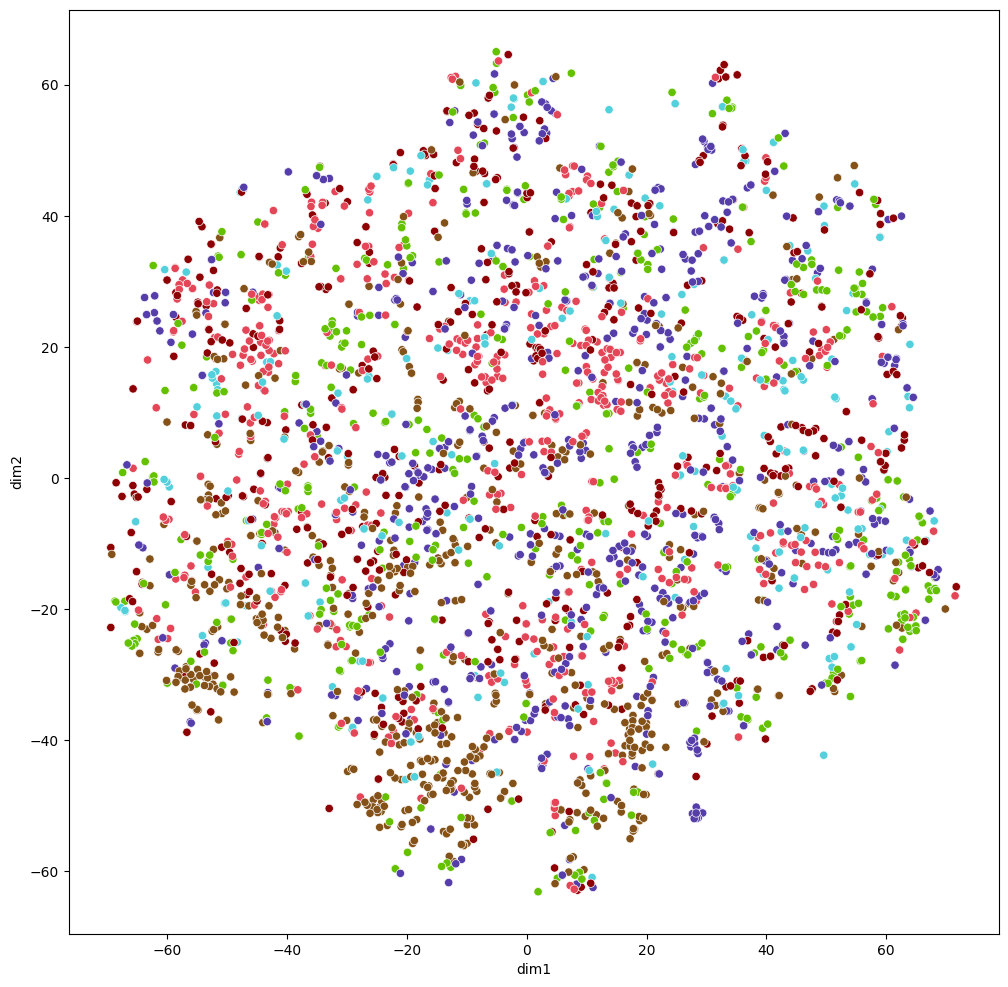

In [24]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
criterion = torch.nn.CrossEntropyLoss()
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss
def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}')
    

Epoch: 001, Loss: 1.7917, Val: 0.4120
Epoch: 002, Loss: 1.6446, Val: 0.4960
Epoch: 003, Loss: 1.4750, Val: 0.5340
Epoch: 004, Loss: 1.2307, Val: 0.5800
Epoch: 005, Loss: 1.0688, Val: 0.6000
Epoch: 006, Loss: 0.9205, Val: 0.6200
Epoch: 007, Loss: 0.7288, Val: 0.6460
Epoch: 008, Loss: 0.5947, Val: 0.6620
Epoch: 009, Loss: 0.5606, Val: 0.6740
Epoch: 010, Loss: 0.4814, Val: 0.6880
Epoch: 011, Loss: 0.4041, Val: 0.6940
Epoch: 012, Loss: 0.3354, Val: 0.7020
Epoch: 013, Loss: 0.3466, Val: 0.7060
Epoch: 014, Loss: 0.3034, Val: 0.7040
Epoch: 015, Loss: 0.2268, Val: 0.6940
Epoch: 016, Loss: 0.2013, Val: 0.6940
Epoch: 017, Loss: 0.1919, Val: 0.6920
Epoch: 018, Loss: 0.1927, Val: 0.6960
Epoch: 019, Loss: 0.1719, Val: 0.6920
Epoch: 020, Loss: 0.1816, Val: 0.6880
Epoch: 021, Loss: 0.2110, Val: 0.6880
Epoch: 022, Loss: 0.2105, Val: 0.6920
Epoch: 023, Loss: 0.1729, Val: 0.6900
Epoch: 024, Loss: 0.1859, Val: 0.6820
Epoch: 025, Loss: 0.1615, Val: 0.6800
Epoch: 026, Loss: 0.1629, Val: 0.6780
Epoch: 027, 

In [27]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6890


/var/folders/3j/nswsh09j5rxcg8c7sj06k4080000gn/T/ipykernel_80538/2097714774.py:10: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


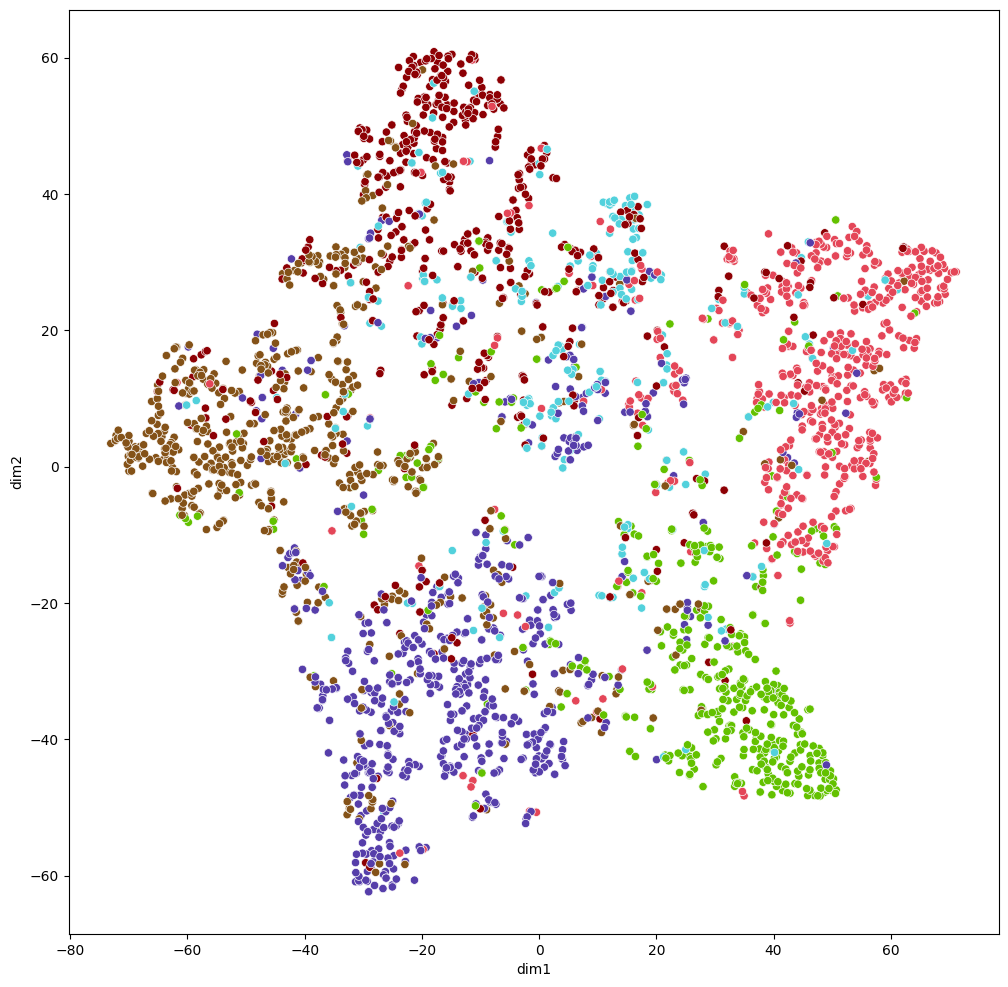

In [28]:
out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)

In [33]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=1)
    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=16, heads=8)
print(model)

GAT(
  (conv1): GATConv(3703, 16, heads=8)
  (conv2): GATConv(128, 6, heads=1)
)


/var/folders/3j/nswsh09j5rxcg8c7sj06k4080000gn/T/ipykernel_80538/2097714774.py:10: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


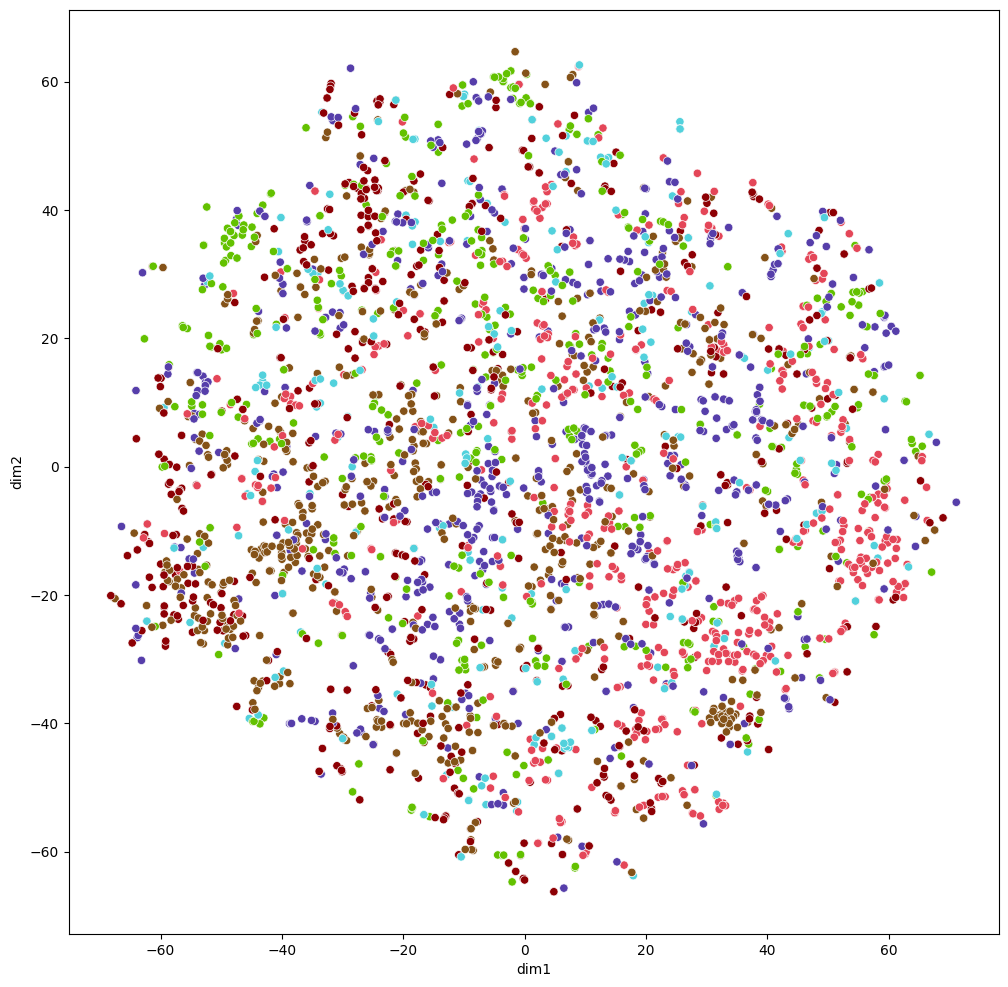

In [34]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-1)
criterion = torch.nn.CrossEntropyLoss()
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc  = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}')

Epoch: 001, Loss: 1.7955, Val: 0.2020
Epoch: 002, Loss: 1.7837, Val: 0.2300
Epoch: 003, Loss: 1.7730, Val: 0.2620
Epoch: 004, Loss: 1.7532, Val: 0.2800
Epoch: 005, Loss: 1.7462, Val: 0.3180
Epoch: 006, Loss: 1.7620, Val: 0.3500
Epoch: 007, Loss: 1.7426, Val: 0.3900
Epoch: 008, Loss: 1.7314, Val: 0.4180
Epoch: 009, Loss: 1.7398, Val: 0.4440
Epoch: 010, Loss: 1.7196, Val: 0.4680
Epoch: 011, Loss: 1.7209, Val: 0.4840
Epoch: 012, Loss: 1.6991, Val: 0.5120
Epoch: 013, Loss: 1.6927, Val: 0.5300
Epoch: 014, Loss: 1.6805, Val: 0.5380
Epoch: 015, Loss: 1.6836, Val: 0.5520
Epoch: 016, Loss: 1.6807, Val: 0.5640
Epoch: 017, Loss: 1.6738, Val: 0.5880
Epoch: 018, Loss: 1.6731, Val: 0.5960
Epoch: 019, Loss: 1.6482, Val: 0.6140
Epoch: 020, Loss: 1.6271, Val: 0.6180
Epoch: 021, Loss: 1.6405, Val: 0.6340
Epoch: 022, Loss: 1.6180, Val: 0.6440
Epoch: 023, Loss: 1.6289, Val: 0.6640
Epoch: 024, Loss: 1.6175, Val: 0.6720
Epoch: 025, Loss: 1.5926, Val: 0.6780
Epoch: 026, Loss: 1.5878, Val: 0.6840
Epoch: 027, 

In [36]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7010


/var/folders/3j/nswsh09j5rxcg8c7sj06k4080000gn/T/ipykernel_80538/2097714774.py:10: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


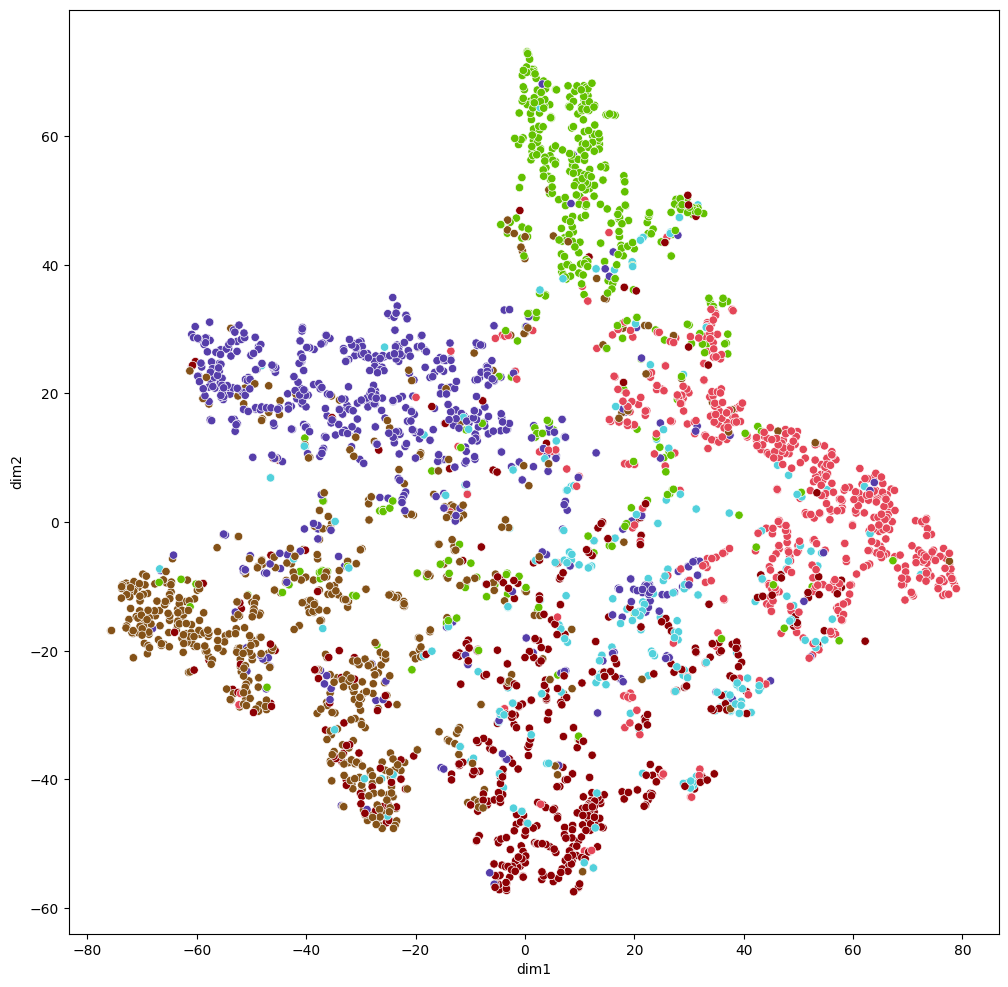

In [37]:
out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)